In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.cpp_extension import load
import time

print(f"PyTorch version: {torch.__version__}")

# ============== SECTION 1: TENSOR BASICS AND STRIDES ==============

# 1.1 Understanding Tensor Structure
# Tensors are the central data structure in PyTorch, consisting of:
# - Data: The actual values
# - Metadata: size, dtype, device, strides, etc.

# Create a simple 2x2 tensor
tensor = torch.tensor([[1, 2], [3, 4]], dtype=torch.float32)
print("Basic tensor:")
print(tensor)
print(f"Shape: {tensor.shape}")
print(f"Dtype: {tensor.dtype}")
print(f"Device: {tensor.device}")

# 1.2 Understanding Strides - One of PyTorch's distinctive features
# Strides tell how many elements to skip to get to the next element in each dimension
print(f"Strides: {tensor.stride()}")  # Typically (stride[0]=2, stride[1]=1) for a 2x2 contiguous tensor

# https://discuss.pytorch.org/t/contigious-vs-non-contigious-tensor/30107
# https://medium.com/analytics-vidhya/pytorch-contiguous-vs-non-contiguous-tensor-view-understanding-view-reshape-73e10cdfa0dd

# 1.3 Views and Strides
# Views create new tensors that share the same underlying storage
# They just modify the metadata (size, strides, offset) without copying data
row = tensor[1, :]  # Get second row
print("\nSecond row as view:")
print(row)
print(f"Is row sharing storage with original? {row.storage().data_ptr() == tensor.storage().data_ptr()}")

print("\n")
print( "*" * 60)

# Column view - note how strides change
col = tensor[:, 0]  # Get first column
print("\nFirst column as view:")
print(col)
print(f"Column strides: {col.stride()}")  # Stride is 2 because we need to jump 2 elements to get the next item in the column


print("\n")
print( "*" * 60)

# 1.4 Storage concept - decouples tensor from physical memory
# A tensor is a view on a storage with size, stride, and offset metadata
print("\nStorage details:")
print(f"Storage size: {tensor.storage().size()}")
print(f"Storage element size: {tensor.element_size()} bytes")
print(f"Storage type: {tensor.storage_type()}")



PyTorch version: 2.6.0+cu124
Basic tensor:
tensor([[1., 2.],
        [3., 4.]])
Shape: torch.Size([2, 2])
Dtype: torch.float32
Device: cpu
Strides: (2, 1)

Second row as view:
tensor([3., 4.])
Is row sharing storage with original? True


************************************************************

First column as view:
tensor([1., 3.])
Column strides: (2,)


************************************************************

Storage details:
Storage size: 4
Storage element size: 4 bytes
Storage type: <class 'torch.FloatStorage'>


In [4]:
# ============== SECTION 2: TENSOR OPERATIONS AND DISPATCH ==============

# 2.1 Operation Dispatching
# Operations in PyTorch follow a two-level dispatch:
# 1. Device type/layout (CPU, CUDA, Sparse, etc.) - dynamic dispatch via virtual methods
# 2. Dtype (float, int, etc.) - static dispatch via switch statements

# Example of operation that will dispatch based on device and dtype
a = torch.ones(3, 3)
b = torch.ones(3, 3)
c = torch.matmul(a, b)

print("\nOperation dispatching example:")
print(f"Input devices: {a.device}, {b.device}")
print(f"Input dtypes: {a.dtype}, {b.dtype}")
print(f"Result: {c}")

# Moving to CUDA changes the dispatch path (if available)
if torch.cuda.is_available():
    a_cuda = a.cuda()
    b_cuda = b.cuda()
    c_cuda = torch.matmul(a_cuda, b_cuda)
    print(f"CUDA tensors: {a_cuda.device}, result shape: {c_cuda.shape}")
    # Brings back to CPU
    a_cuda = a_cuda.cpu()




Operation dispatching example:
Input devices: cpu, cpu
Input dtypes: torch.float32, torch.float32
Result: tensor([[3., 3., 3.],
        [3., 3., 3.],
        [3., 3., 3.]])


In [5]:
# ============== SECTION 3: CREATING AN OPERATOR ==============

# Implementing a simple custom operation
# Note: Here we're showing a simplified version of what happens in PyTorch C++ code

def my_elementwise_add(tensor1, tensor2, alpha=1):
    """
    Demonstrates the structure of a PyTorch operator
    This mirrors how it would be structured in the C++ codebase
    """
    # 1. Error checking
    assert tensor1.device == tensor2.device, "Expected tensors on same device"
    assert tensor1.dtype == tensor2.dtype, "Expected same dtype"
    assert tensor1.shape == tensor2.shape, "Expected same shape"

    # 2. Result allocation
    result = torch.empty_like(tensor1)

    # 3. Dispatch based on device
    if tensor1.is_cuda:
        print("Would dispatch to CUDA implementation")
        # In C++: call CUDA kernel
        result = tensor1 + alpha * tensor2  # Using PyTorch's implementation
    else:
        print("Dispatching to CPU implementation")
        # In real implementation, we would dispatch to different dtype implementations
        # We simulate how it would be structured
        if tensor1.dtype == torch.float32:
            # CPU float32 implementation
            result = tensor1 + alpha * tensor2
        elif tensor1.dtype == torch.int64:
            # CPU int64 implementation
            result = tensor1 + alpha * tensor2
        else:
            # Other dtype implementations
            result = tensor1 + alpha * tensor2

    return result

# Test our custom operation
a = torch.tensor([1, 2, 3], dtype=torch.float32)
b = torch.tensor([4, 5, 6], dtype=torch.float32)
result = my_elementwise_add(a, b, alpha=2)
print("\nCustom operation result:")
print(result)  # Should be [9, 12, 15]



Dispatching to CPU implementation

Custom operation result:
tensor([ 9., 12., 15.])


In [23]:
# ============== SECTION 4: TENSOR ACCESSORS AND ITERATORS ==============

def demonstrate_tensor_access_patterns():
    """
    Demonstrates different ways to access tensor data as explained in the document
    """
    # Create a 2x3 tensor
    tensor = torch.tensor([[1, 2, 3],
                           [4, 5, 6]], dtype=torch.float32)

    # Method 1: Element-by-element access (slowest, but most straightforward)
    print("\nElement access demonstration:")
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            print(f"tensor[{i}, {j}] = {tensor[i, j]}")

    # Method 2: Using numpy-like indexing (more Pythonic)
    print("\nNumpy-like indexing:")
    print(f"First row: {tensor[0, :]}")
    print(f"Second column: {tensor[:, 1]}")


    print("\n")
    print( "*" * 60)


    # Method 3: Using .item() for single elements
    print("\nUsing .item():")
    print(f"First element as Python scalar: {tensor[0, 0].item()}")



    print("\n")
    print( "*" * 60)

    # Method 4: Converting to numpy (for interoperability)
    np_array = tensor.numpy()
    print("\nConverted to numpy:")
    print(np_array)



    print("\n")
    print( "*" * 60)


    # Method 5: Vectorized operations (most efficient for bulk operations)
    print("\nVectorized operations:")
    result = tensor * 2 + 1
    print(result)

# Run the demonstration
demonstrate_tensor_access_patterns()




Element access demonstration:
tensor[0, 0] = 1.0
tensor[0, 1] = 2.0
tensor[0, 2] = 3.0
tensor[1, 0] = 4.0
tensor[1, 1] = 5.0
tensor[1, 2] = 6.0

Numpy-like indexing:
First row: tensor([1., 2., 3.])
Second column: tensor([2., 5.])


************************************************************

Using .item():
First element as Python scalar: 1.0


************************************************************

Converted to numpy:
[[1. 2. 3.]
 [4. 5. 6.]]


************************************************************

Vectorized operations:
tensor([[ 3.,  5.,  7.],
        [ 9., 11., 13.]])


In [22]:
# ============== SECTION 5: AUTOGRAD MECHANISM ==============

def demonstrate_autograd():
    """
    Demonstrates how PyTorch's autograd works
    This mirrors the explanation in the document about computing gradients
    """
    print("\nAutograd demonstration:")

    # Create tensors with grad tracking
    W_x = torch.tensor([[0.1, 0.2]], requires_grad=True)  # 1x2
    x = torch.tensor([[1.0], [2.0]], requires_grad=True)  # 2x1
    W_h = torch.tensor([[0.3]], requires_grad=True)       # 1x1
    prev_h = torch.tensor([[0.5]], requires_grad=True)    # 1x1

    # Forward pass (similar to the RNN example in the document)
    i2h = torch.mm(W_x, x)                                # Input to hidden
    h2h = torch.mm(W_h, prev_h)                           # Hidden to hidden
    next_h = i2h + h2h                                    # Next hidden state
    next_h = torch.tanh(next_h)                           # Apply activation
    loss = next_h.sum()                                   # Loss function

    print("Forward pass values:")
    print(f"i2h: {i2h}")
    print(f"h2h: {h2h}")
    print(f"next_h before tanh: {i2h + h2h}")
    print(f"next_h after tanh: {next_h}")
    print(f"loss: {loss}")

    # Backward pass
    loss.backward()

    print("\n")
    print( "*" * 60)
    print("\nGradients after backward pass:")
    print(f"W_x.grad: {W_x.grad}")
    print(f"x.grad: {x.grad}")
    print(f"W_h.grad: {W_h.grad}")
    print(f"prev_h.grad: {prev_h.grad}")
    print('-'*20)

    # This is what happens behind the scenes:
    # 1. PyTorch builds a computation graph during forward pass
    # 2. Each operation has a corresponding backward function
    # 3. Autograd engine traverses this graph backwards to compute gradients
    # 4. Results are stored in .grad attributes of tensors

demonstrate_autograd()




Autograd demonstration:
Forward pass values:
i2h: tensor([[0.5000]], grad_fn=<MmBackward0>)
h2h: tensor([[0.1500]], grad_fn=<MmBackward0>)
next_h before tanh: tensor([[0.6500]], grad_fn=<AddBackward0>)
next_h after tanh: tensor([[0.5717]], grad_fn=<TanhBackward0>)
loss: 0.5716699361801147


************************************************************

Gradients after backward pass:
W_x.grad: tensor([[0.6732, 1.3464]])
x.grad: tensor([[0.0673],
        [0.1346]])
W_h.grad: tensor([[0.3366]])
prev_h.grad: tensor([[0.2020]])
--------------------


In [21]:
# ============== SECTION 6: CODEBASE STRUCTURE ==============



def codebase_structure_guide():
    """
    Guide to PyTorch's codebase structure as explained in the document
    """
    print("\nPyTorch Codebase Structure Guide:")

    structure = {
        "torch/": "Python modules (frontend)",
        "torch/csrc/": "C++ code, Python bindings, autograd, JIT",
        "aten/": "A TENsor library - core tensor operations",
        "aten/src/ATen/native/": "Modern C++ implementations",
        "aten/src/ATen/TH, THC, etc.": "Legacy C implementations",
        "c10/": "Core abstractions (TensorImpl, etc.)"
    }

    for path, description in structure.items():
        print(f"{path:<25} {description}")

    print("\n")
    print( "*" * 60)

    print("\nKey files for understanding dispatching:")
    dispatch_files = [
        "torch/csrc/autograd/generated/python_torch_functions.cpp",
        "torch/csrc/autograd/VariableType.cpp",
        "aten/src/ATen/TypeDefault.cpp",
        "aten/src/ATen/native/BinaryOps.cpp"
    ]

    for file in dispatch_files:
        print(f"- {file}")

codebase_structure_guide()




PyTorch Codebase Structure Guide:
torch/                    Python modules (frontend)
torch/csrc/               C++ code, Python bindings, autograd, JIT
aten/                     A TENsor library - core tensor operations
aten/src/ATen/native/     Modern C++ implementations
aten/src/ATen/TH, THC, etc. Legacy C implementations
c10/                      Core abstractions (TensorImpl, etc.)


************************************************************

Key files for understanding dispatching:
- torch/csrc/autograd/generated/python_torch_functions.cpp
- torch/csrc/autograd/VariableType.cpp
- aten/src/ATen/TypeDefault.cpp
- aten/src/ATen/native/BinaryOps.cpp


In [9]:

# ============== SECTION 7: WORKFLOW EFFICIENCY TIPS ==============

def workflow_efficiency_tips():
    """
    Practical tips for efficiently working with PyTorch's codebase
    """
    print("\nWorkflow Efficiency Tips:")

    tips = [
        "Don't edit headers frequently - they cause long rebuilds",
        "Avoid testing only via CI - setup a local development environment",
        "Set up ccache to speed up rebuilds",
        "Use a powerful workstation for builds, especially for CUDA",
        "Modify .cpp files instead of headers when possible",
        "Consider porting legacy TH code to ATen when you can",
        "Use precompiled debug builds to step through code paths"
    ]

    for i, tip in enumerate(tips, 1):
        print(f"{i}. {tip}")

workflow_efficiency_tips()




Workflow Efficiency Tips:
1. Don't edit headers frequently - they cause long rebuilds
2. Avoid testing only via CI - setup a local development environment
3. Set up ccache to speed up rebuilds
4. Use a powerful workstation for builds, especially for CUDA
5. Modify .cpp files instead of headers when possible
6. Consider porting legacy TH code to ATen when you can
7. Use precompiled debug builds to step through code paths


In [10]:
# ============== SECTION 8: EXTENSION POINTS ==============

def tensor_extension_points():
    """
    Demonstrates the extension points in PyTorch tensors
    """
    print("\nTensor Extension Points:")

    # The "trinity" of extension points:
    trinity = {
        "device": "Where the tensor lives (CPU, CUDA, etc.) - has its own allocator",
        "layout": "How data is logically interpreted (strided, sparse, etc.)",
        "dtype": "Data type of elements (float, int, qint8, etc.)"
    }

    for point, description in trinity.items():
        print(f"{point:<10} {description}")

    # Examples of built-in implementations:
    print("\nExamples of existing implementations:")

    devices = ["cpu", "cuda", "xla", "mps"]
    layouts = ["strided", "sparse", "sparse_csr"]
    dtypes = ["float32", "float16", "int64", "bool", "quint8"]

    print(f"Devices: {', '.join(devices)}")
    print(f"Layouts: {', '.join(layouts)}")
    print(f"Dtypes: {', '.join(dtypes)}")

    print("\nNot all combinations have kernels implemented!")

tensor_extension_points()




Tensor Extension Points:
device     Where the tensor lives (CPU, CUDA, etc.) - has its own allocator
layout     How data is logically interpreted (strided, sparse, etc.)
dtype      Data type of elements (float, int, qint8, etc.)

Examples of existing implementations:
Devices: cpu, cuda, xla, mps
Layouts: strided, sparse, sparse_csr
Dtypes: float32, float16, int64, bool, quint8

Not all combinations have kernels implemented!



Stride visualization:
Tensor shape: torch.Size([2, 3])
Tensor strides: (3, 1)

Transposed tensor strides: (1, 3)
Notice how strides are swapped after transpose.


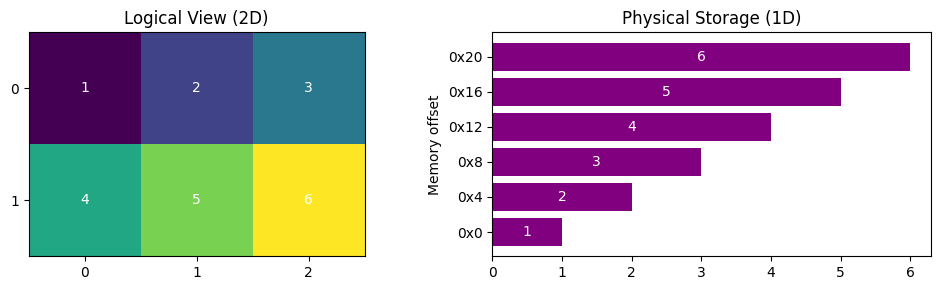

In [13]:
# ============== BONUS: VISUALIZING TENSOR STRIDES ==============

def visualize_strides():
    """
    Creates a visual representation of stride concepts
    """
    # Create a 2x3 tensor
    tensor = torch.tensor([[1, 2, 3],
                          [4, 5, 6]], dtype=torch.float32)

    print("\nStride visualization:")
    print(f"Tensor shape: {tensor.shape}")
    print(f"Tensor strides: {tensor.stride()}")

    # Physical representation in memory (contiguous)
    physical = tensor.storage()

    # Visualize the relationship
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    # Logical view (2D)
    ax1.set_title("Logical View (2D)")
    ax1.imshow(tensor.numpy(), cmap='viridis')
    for i in range(tensor.shape[0]):
        for j in range(tensor.shape[1]):
            ax1.text(j, i, f"{tensor[i, j]:.0f}", ha="center", va="center", color="w")
    ax1.set_xticks(range(tensor.shape[1]))
    ax1.set_yticks(range(tensor.shape[0]))

    # Physical view (1D storage)
    ax2.set_title("Physical Storage (1D)")
    physical_arr = np.array([physical[i] for i in range(physical.size())])
    ax2.barh(range(len(physical_arr)), physical_arr, color='purple')
    for i, val in enumerate(physical_arr):
        ax2.text(val/2, i, f"{val:.0f}", ha="center", va="center", color="w")
    ax2.set_yticks(range(len(physical_arr)))
    ax2.set_yticklabels([f"0x{i*4}" for i in range(len(physical_arr))])
    ax2.set_ylabel("Memory offset")

    plt.tight_layout()

    # Show transposed view to demonstrate stride changes
    transposed = tensor.t()
    print(f"\nTransposed tensor strides: {transposed.stride()}")
    print("Notice how strides are swapped after transpose.")

visualize_strides()